In [14]:
import glob
from PIL import Image
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.nn import functional as F

In [15]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [16]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [17]:
path_to_training_data = '/Users/jshlomi/Desktop/Datasets/homework1/Dataset/train/'
path_to_validation_data = '/Users/jshlomi/Desktop/Datasets/homework1/Dataset/validation/'

In [18]:
class CustomDataset(Dataset):
    def __init__(self, path,mean=0.092,std=0.127,n_classes=10,transform=False):
        
        self.do_transform = transform
        self.transform = transforms.RandomRotation(180)
        
        self.filelist = glob.glob(path+'/*.png')
        
        self.labels = np.zeros(len(self.filelist))
        
        for class_i in range(n_classes):
            self.labels[ np.array(['class'+str(class_i) in x for x in self.filelist]) ] = class_i
        self.labels = torch.LongTensor(self.labels)
        if torch.cuda.is_available():
            self.labels = self.labels.cuda()
        
        self.mean = mean
        self.std = std
        
    def __len__(self):
       
        return len(self.filelist)


    def __getitem__(self, idx):
        
        img = Image.open(self.filelist[idx])

        if self.do_transform:
            
            img = self.transform(img)
            
        x = transforms.ToTensor()(img).view(-1)
        x = (x-self.mean)/self.std
        
        y = self.labels[idx]
    
        return x, y

In [19]:
from pytorch_lightning.core.lightning import LightningModule

In [26]:
class LitModel(LightningModule):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(4761, 4761)
        self.layer2 = nn.Linear(4761, 10)
        self.acti = nn.ReLU()
        
    def forward(self, x):
        out = self.acti(self.layer1(x)) 
        out = self.layer2(out)
        
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        
        return {'loss': loss, 'log': {'train_loss': loss.item()}}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr=2e-05)

    def train_dataloader(self):
        dataset = CustomDataset(path_to_training_data,transform=False)
        loader = DataLoader(dataset, batch_size=120,shuffle=True,num_workers=4)
        return loader
    
    def val_dataloader(self):
        
        dataset = CustomDataset(path_to_validation_data,transform=False)
        loader = DataLoader(dataset, batch_size=120,num_workers=4)
        return loader
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return {'val_loss': F.cross_entropy(y_hat, y)}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        
        return {'val_loss': avg_loss, 'log': {'val_loss': avg_loss}}



In [27]:
from pytorch_lightning import Trainer

In [28]:
model = LitModel()

In [29]:
trainer = Trainer(max_epochs=10)

INFO:lightning:GPU available: False, used: False


In [24]:
lr_finder = trainer.lr_find(model)

INFO:lightning:
  | Name   | Type   | Params
------------------------------
0 | layer1 | Linear | 22 M  
1 | layer2 | Linear | 47 K  
2 | acti   | ReLU   | 0     


INFO:lightning:LR finder stopped early due to diverging loss.


9.120108393559096e-06


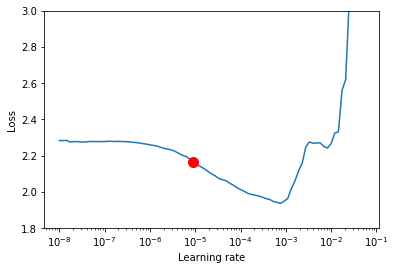

In [25]:
fig = lr_finder.plot(suggest=True)

plt.ylim(1.8,3)

print(lr_finder.suggestion())

In [30]:
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 54274), started 1:31:47 ago. (Use '!kill 54274' to kill it.)

In [31]:
trainer.fit(model)

INFO:lightning:
  | Name   | Type   | Params
------------------------------
0 | layer1 | Linear | 22 M  
1 | layer2 | Linear | 47 K  
2 | acti   | ReLU   | 0     


1

In [32]:
import os
from pytorch_lightning.loggers import CometLogger


comet_logger = CometLogger(
    api_key='hIKK5onYgoMtN9QxQh5qcrDg9',
    save_dir='.',  # Optional
    experiment_name='test4'  # Optional
)

INFO:lightning:CometLogger will be initialized in online mode
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/jshlomi/general/b12690e8c63d4445ab9f5d6cec5659a7



In [33]:
model = LitModel()
trainer = Trainer(max_epochs=10,logger=comet_logger)

INFO:lightning:GPU available: False, used: False


In [ ]:
trainer.fit(model)

INFO:lightning:
  | Name   | Type   | Params
------------------------------
0 | layer1 | Linear | 22 M  
1 | layer2 | Linear | 47 K  
2 | acti   | ReLU   | 0     


In [ ]:
comet_logger.experiment.display()